<a href="https://colab.research.google.com/github/Flopezc4/AI-Fred/blob/main/Cuaderno_Python/Open_cv_ocr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parte 1 -- Detectar patente  
Detectar la patente atraves del uso de filtro y contornos, para posteriormente poder guardar unicamente la patente de una imagen


In [ ]:
!pip install opencv-contrib-python-headless
!pip install matplotlib
!pip install scikit-image
!pip install -q keras-ocr
!pip install numpy

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import keras_ocr
import skimage

## Carga de imagen

(1200, 1600, 3)


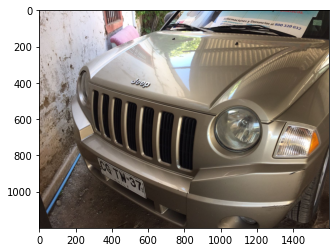

In [ ]:
img = cv2.imread('/content/auto2.jpeg')
print(img.shape)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

## 1 Filtro Gris
Pasamos la imagen a blanco y negro, con la funcion cvtColor de cv2, es decir pasa de 3 canales a solo 1

(1200, 1600)


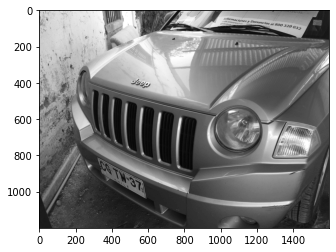

In [ ]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print(gray.shape)
plt.imshow(gray, cmap='gray')
plt.show()

## 2 Filtro Threshold
Si el pixel es mayor a 175 lo dejamos a 255, nos quedamos con una imagen con valores de 0 o 255

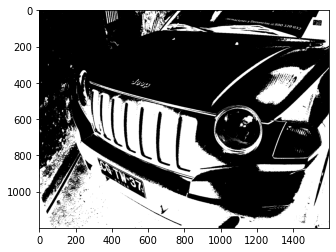

In [ ]:
th = cv2.threshold(gray, 80, 255, cv2.THRESH_BINARY_INV)[1]
plt.imshow(th, cmap='gray')
plt.show()

In [ ]:
# Comparacion con la imagen antigua y la nueva
[gray,th]

[array([[214, 211, 211, ...,  31,  34,  36],
        [214, 209, 207, ...,  31,  34,  36],
        [211, 212, 212, ...,  32,  34,  35],
        ...,
        [ 25,  26,  26, ...,  45,  49,  46],
        [ 29,  27,  26, ...,  44,  48,  48],
        [ 32,  29,  26, ...,  47,  51,  51]], dtype=uint8),
 array([[  0,   0,   0, ..., 255, 255, 255],
        [  0,   0,   0, ..., 255, 255, 255],
        [  0,   0,   0, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)]

## 3 Filtro para obtener los contornos
FindContours devuelve los contornos de una imagen, se le aplica esta función a la imagen threshold

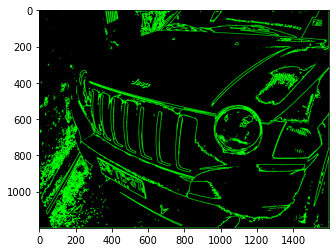

In [ ]:
contours = cv2.findContours(th, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]
canvas = np.zeros_like(img)
cv2.drawContours(canvas , contours, -1, (0, 255, 0), 2)
#plt.axis('off')
plt.imshow(canvas, cmap='gray')
plt.show()


## 4 Eliminar los contornos que no son candidatos
por el caso de uso que usaremos podemos determinar que la patente tiene aproximadamente X tamaño por lo cual los contornos muy grande se elimana al igual que los contornos muy pequeños



*   **Largo** : 360 milimetros
*   **Ancho** : 130 milimetros
*   tipo de letra Fe-Schrift o Fälschungserschnerende Schrift de un alto de 70 milímetros
*   El símbolo del escudo o logotipo no podrán ser mayores a 20 por 20 milímetros
*   Letras de la palabra "Chile" serán del tipo Fe-Schrift o Fälschungserschnerende Schrift de un alto
de 15 milímetros
*   El punto que separa en grupos de a dos a las letras de las combinaciones o de cuatro letras y
dos dígitos, no será mayor de 10 milímetros de diámetro.




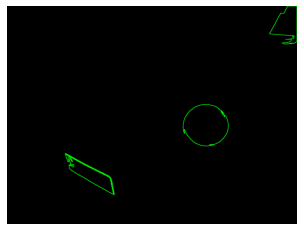

In [ ]:
# Patente chilena ratio = 360 / 130 = 2.769230769
candidates = []
ratio = 3.2
max_w = 300
min_w = 100

min_h = 150
max_h = 300

for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    aspect_ratio = float(w) / h
    # SI el aspecratio es similar Y el ancho Y el alto es Similar , es candidato
    #np.isclose(aspect_ratio, ratio, atol=1.0) and
    if ( (max_w > w > min_w) and (max_h > h > min_h)):
        candidates.append(cnt)

# redibujamos los contornos que nos quedan, despues de aplicar un filtro

canvas = np.zeros_like(img)
cv2.drawContours(canvas , candidates, -1, (0, 255, 0), 2)
plt.axis('off')
plt.imshow(canvas);

# Pantente arg 99, 397, 109, 42

In [ ]:
cv2.boundingRect(candidates[0])

(323, 818, 264, 218)

## 5 Filtro de contornos 2
para los contornos que se asimilen en tamaño, filtramos por posision , la patente de un auto tipicamente se encuentra en la parte inferior central del auto

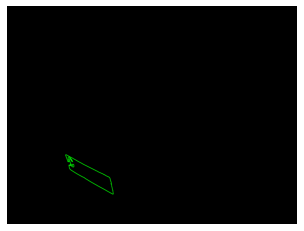

In [ ]:
ys = []
for cnt in candidates:
    x, y, w, h = cv2.boundingRect(cnt)
    ys.append(y)

license = candidates[np.argmax(ys)]


canvas = np.zeros_like(img)
cv2.drawContours(canvas , [license], -1, (0, 255, 0), 2)
plt.axis('off')
plt.imshow(canvas);



## Cortar
una vez encontrado nuestro contorno lo cortamos

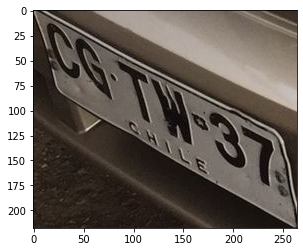

In [ ]:
x, y, w, h = cv2.boundingRect(license)
cropped = gray[y:y+h,x:x+w]
x, y, w, h = cv2.boundingRect(license)
cropped2 = img[y:y+h,x:x+w]
plt.imshow(cv2.cvtColor(cropped2, cv2.COLOR_BGR2RGB))
plt.show()

## Volvemos a aplicar el filtro gris 
ahora solamente a la imagen que obtenemos

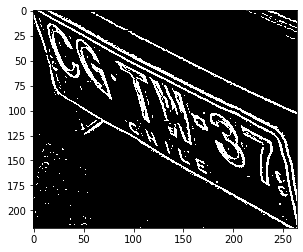

In [ ]:
thresh_cropped = cv2.adaptiveThreshold(cropped, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 7, 13)
plt.imshow(thresh_cropped, cmap='gray')
plt.show()

## skimage limpia los contornos
para obtener una mejor imagen

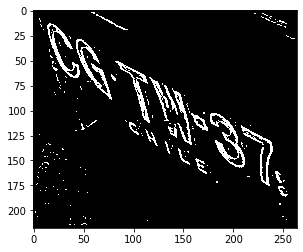

In [ ]:
clear_border = skimage.segmentation.clear_border(thresh_cropped)
plt.imshow(clear_border, cmap='gray')
plt.show()

## invertimos los colores

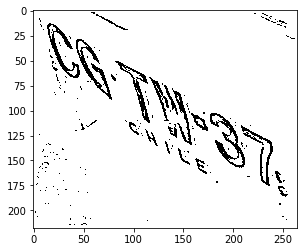

In [ ]:
final = cv2.bitwise_not(clear_border)
plt.imshow(final, cmap='gray')
plt.show()

## Finalmente Obtenomos los dijitos y nos faltaria un modelo que dejecte los caracteres 

In [ ]:
cv2.imwrite('CGTW37.png',final)

True

# Parte 2 -- Detectar carcteres

In [ ]:
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /root/.keras-ocr/craft_mlt_25k.h5
Looking for /root/.keras-ocr/crnn_kurapan.h5


In [ ]:
images = keras_ocr.tools.read('/content/CGTW37.png') 

In [ ]:
prediction_groups = pipeline.recognize([images])

1/1 [==============================] - 4s 4s/step


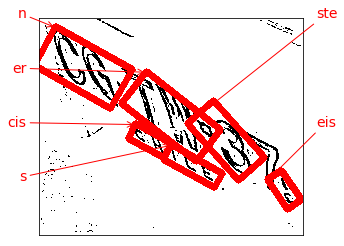

In [ ]:
keras_ocr.tools.drawAnnotations(image=images, predictions=prediction_groups[0])

## Prueba TESERAKE ???

## Prueba open orc ???


## Prueba Modelo propio ??